## Importing Libraries


In [1]:
import requests
from bs4 import BeautifulSoup, NavigableString, Tag
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud

## Downloading the Webpage

In [5]:
# URL page web
URL = 'https://books.toscrape.com/'
response = requests.get(URL)

# Loading the content into a file
with open('Bookswebpage.html','w') as file:
    file.write(page_contents)

In [6]:
response.text[1:]

'!DOCTYPE html>\n<!--[if lt IE 7]>      <html lang="en-us" class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->\n<!--[if IE 7]>         <html lang="en-us" class="no-js lt-ie9 lt-ie8"> <![endif]-->\n<!--[if IE 8]>         <html lang="en-us" class="no-js lt-ie9"> <![endif]-->\n<!--[if gt IE 8]><!--> <html lang="en-us" class="no-js"> <!--<![endif]-->\n    <head>\n        <title>\n    All products | Books to Scrape - Sandbox\n</title>\n\n        <meta http-equiv="content-type" content="text/html; charset=UTF-8" />\n        <meta name="created" content="24th Jun 2016 09:29" />\n        <meta name="description" content="" />\n        <meta name="viewport" content="width=device-width" />\n        <meta name="robots" content="NOARCHIVE,NOCACHE" />\n\n        <!-- Le HTML5 shim, for IE6-8 support of HTML elements -->\n        <!--[if lt IE 9]>\n        <script src="//html5shim.googlecode.com/svn/trunk/html5.js"></script>\n        <![endif]-->\n\n        \n            <link rel="shortcut icon" href=

We observe that the reponse is very messy. In BeatifulSoup these results will be more readable.

In [7]:
page_contents = response.text

In [8]:
#Loading the content into a file
with open('Bookswebpage.html','w') as file:
    file.write(page_contents)


## Parse and Extracte informations

In [9]:
document = BeautifulSoup(page_contents,'html.parser')

In [10]:
print(document.prettify()[1:])

!DOCTYPE html>
<!--[if lt IE 7]>      <html lang="en-us" class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->
<!--[if IE 7]>         <html lang="en-us" class="no-js lt-ie9 lt-ie8"> <![endif]-->
<!--[if IE 8]>         <html lang="en-us" class="no-js lt-ie9"> <![endif]-->
<!--[if gt IE 8]><!-->
<html class="no-js" lang="en-us">
 <!--<![endif]-->
 <head>
  <title>
   All products | Books to Scrape - Sandbox
  </title>
  <meta content="text/html; charset=utf-8" http-equiv="content-type"/>
  <meta content="24th Jun 2016 09:29" name="created"/>
  <meta content="" name="description"/>
  <meta content="width=device-width" name="viewport"/>
  <meta content="NOARCHIVE,NOCACHE" name="robots"/>
  <!-- Le HTML5 shim, for IE6-8 support of HTML elements -->
  <!--[if lt IE 9]>
        <script src="//html5shim.googlecode.com/svn/trunk/html5.js"></script>
        <![endif]-->
  <link href="static/oscar/favicon.ico" rel="shortcut icon"/>
  <link href="static/oscar/css/styles.css" rel="stylesheet" type="text

## Finding URL of the main page

In [11]:
# In order not to get messy results we add 'div.a.get('href')'
document.find("article", class_ = "product_pod").div.a.get('href')

'catalogue/a-light-in-the-attic_1000/index.html'

## Finding Book Categories URL

In [12]:
categories_urls = [URL + x.get('href') for x in document.find_all("a", href=re.compile("catalogue/category/books"))]
categories_urls = categories_urls[1:] # we remove the first one because it corresponds to all the books

print(str(len(categories_urls)) + " fetched categories URLs")
print("Some examples:")
categories_urls

50 fetched categories URLs
Some examples:


['https://books.toscrape.com/catalogue/category/books/travel_2/index.html',
 'https://books.toscrape.com/catalogue/category/books/mystery_3/index.html',
 'https://books.toscrape.com/catalogue/category/books/historical-fiction_4/index.html',
 'https://books.toscrape.com/catalogue/category/books/sequential-art_5/index.html',
 'https://books.toscrape.com/catalogue/category/books/classics_6/index.html',
 'https://books.toscrape.com/catalogue/category/books/philosophy_7/index.html',
 'https://books.toscrape.com/catalogue/category/books/romance_8/index.html',
 'https://books.toscrape.com/catalogue/category/books/womens-fiction_9/index.html',
 'https://books.toscrape.com/catalogue/category/books/fiction_10/index.html',
 'https://books.toscrape.com/catalogue/category/books/childrens_11/index.html',
 'https://books.toscrape.com/catalogue/category/books/religion_12/index.html',
 'https://books.toscrape.com/catalogue/category/books/nonfiction_13/index.html',
 'https://books.toscrape.com/catalogue

## Selecting 10 Book Categories

In this project is I collected the informations of only 10 book's categories and not all 50, therefore I only selected the first 10 categories since they contain the highest number of books.

In [20]:
#categories_urls_10 = categories_urls[:10]
categories_urls_10 = categories_urls

## Getting Books URL for the selected categories

In [21]:
#Define a function to request and parse HTML webpage
def getAndParseURL(url):
    result = requests.get(url)
    soup = BeautifulSoup(result.text, 'html.parser')
    return(soup)

In [22]:
# Defining a function to retrieve book links from each categorie
def getBooksURLs(url):
    soup = getAndParseURL(url)
    # remove the index.html part of the base url before returning the results
    return(["/".join(url.split("/")[:-1]) + "/" + x.div.a.get('href') for x in soup.findAll("article", class_ = "product_pod")])


In [23]:
# In each book category there might be fiew pages containing the books
#in this code bellow I will iterate on each page in the book catergories (if there is more then one page)

pages_urls_categories_10 = []

for pages_categorie in categories_urls_10:
    
    soup = getAndParseURL(pages_categorie)
    if  not soup.findAll("a", href=re.compile("page")) == [] : # this line is to check is in this book categorie there is fiew pages of books
        pages_urls_categories_10.append(pages_categorie)
        while not soup.findAll('li' , class_ = 'next') == [] : # this line is to check if there is still a next page. Indeed while the botton 'next' excist, this indicates that there is still another page of books
    
            # get the new complete url by adding the fetched URL to the base URL (and removing the index.html part of the base URL)
            new_url = "/".join(pages_categorie.split('/')[:-1]) + "/" + soup.findAll("a", href=re.compile("page"))[-1].get("href")
    
            # add the URL to the list
            pages_urls_categories_10.append(new_url)
        
            # parse the next page
            soup = getAndParseURL(new_url)
    else: # if the book category is only one page then I'll add it's url to the list
        pages_urls_categories_10.append(pages_categorie)
        
pages_urls_categories_10

['https://books.toscrape.com/catalogue/category/books/travel_2/index.html',
 'https://books.toscrape.com/catalogue/category/books/mystery_3/index.html',
 'https://books.toscrape.com/catalogue/category/books/mystery_3/page-2.html',
 'https://books.toscrape.com/catalogue/category/books/historical-fiction_4/index.html',
 'https://books.toscrape.com/catalogue/category/books/historical-fiction_4/page-2.html',
 'https://books.toscrape.com/catalogue/category/books/sequential-art_5/index.html',
 'https://books.toscrape.com/catalogue/category/books/sequential-art_5/page-2.html',
 'https://books.toscrape.com/catalogue/category/books/sequential-art_5/page-3.html',
 'https://books.toscrape.com/catalogue/category/books/sequential-art_5/page-4.html',
 'https://books.toscrape.com/catalogue/category/books/classics_6/index.html',
 'https://books.toscrape.com/catalogue/category/books/philosophy_7/index.html',
 'https://books.toscrape.com/catalogue/category/books/romance_8/index.html',
 'https://books.to

In [31]:
len(pages_urls_categories_10)

80

In [24]:
booksURLs = []
for page in pages_urls_categories_10:
    booksURLs.extend(getBooksURLs(page))
    
print(str(len(booksURLs)) + " fetched URLs")
print("Some examples:")
booksURLs[:5]

1000 fetched URLs
Some examples:


['https://books.toscrape.com/catalogue/category/books/travel_2/../../../its-only-the-himalayas_981/index.html',
 'https://books.toscrape.com/catalogue/category/books/travel_2/../../../full-moon-over-noahs-ark-an-odyssey-to-mount-ararat-and-beyond_811/index.html',
 'https://books.toscrape.com/catalogue/category/books/travel_2/../../../see-america-a-celebration-of-our-national-parks-treasured-sites_732/index.html',
 'https://books.toscrape.com/catalogue/category/books/travel_2/../../../vagabonding-an-uncommon-guide-to-the-art-of-long-term-world-travel_552/index.html',
 'https://books.toscrape.com/catalogue/category/books/travel_2/../../../under-the-tuscan-sun_504/index.html']

## Get Book data

In [34]:
names = []
prices = []
nb_in_stock = []
img_urls = []
categories = []
ratings = []
description = []

# scrape data for every book URL: this may take some time
for url in booksURLs:
    soup = getAndParseURL(url)
    # product name
    names.append(soup.find("div", class_ = re.compile("product_main")).h1.text)
    
    # product price
    prices.append(soup.find("p", class_ = "price_color").text[2:]) # get rid of the pound sign
    
    # number of available products
    nb_in_stock.append(re.sub("[^0-9]", "", soup.find("p", class_ = "instock availability").text)) # get rid of non numerical characters
    
    # image url
    img_urls.append(url.replace("index.html", "") + soup.find("img").get("src"))
    
    # product category
    categories.append(soup.find("a", href = re.compile("../category/books/")).get("href").split("/")[3])
    
    # ratings
    ratings.append(soup.find("p", class_ = re.compile("star-rating")).get("class")[1])
    
    # description
    # After observing the html of book categorie webpage, it is shown that the book description is after the 4th <p>
    text = []
    for i in soup.find_all('p'):
        text.append(i)
    description.append(text[3])
    

## Transform the data into dataframe in pandas

In [35]:
Book_Data = pd.DataFrame({'name': names, 'price': prices, 'nb_in_stock': nb_in_stock, "url_img": img_urls, "product_category": categories, "rating": ratings,"description" : description})
Book_Data.shape

(1000, 7)

## Data Cleaning

In [36]:
# checking the data type

dataTypeSeries = Book_Data.dtypes
print('Data type of each column of Dataframe :')
print(dataTypeSeries)

Data type of each column of Dataframe :
name                object
price               object
nb_in_stock         object
url_img             object
product_category    object
rating              object
description         object
dtype: object


In [37]:
Book_Data["rating"] = Book_Data["rating"].replace({"One" : 1 , "Two" : 2, "Three" : 3 , "Four":4, "Five" : 5})

In [38]:
#Converting the book data to the right data type
Book_Data['nb_in_stock']=Book_Data['nb_in_stock'].astype(str).astype(int)
Book_Data[['price','rating']]=Book_Data[['price','rating']].astype(str).astype(float)
Book_Data[['name',"url_img","product_category","description"]]=Book_Data[['name',"url_img","product_category","description"]].astype('string')


In [39]:
dataTypeSeries_After = Book_Data.dtypes
print('Data type of each column of Dataframe :')
print(dataTypeSeries_After)

Data type of each column of Dataframe :
name                string[python]
price                      float64
nb_in_stock                  int32
url_img             string[python]
product_category    string[python]
rating                     float64
description         string[python]
dtype: object


0        travel
1        travel
2        travel
3        travel
4        travel
         ...   
995    politics
996    politics
997    cultural
998     erotica
999       crime
Name: 0, Length: 1000, dtype: string

In [54]:
#Removing the last characters from the book category after "_"
Book_Data["product_category"]=Book_Data["product_category"].str.split("_",n= 1, expand = True)[0]

#Removing the first 3 characters from book description and the last 13 ( ...more</p>')
Book_Data["description"]  = Book_Data["description"].str[3:-13]

Book_Data.head()

,name,price,nb_in_stock,url_img,product_category,rating,description
0,It's Only the Himalayas,45.17,19,https://books.toscrape.com/catalogue/category/...,travel,2.0,"âWherever you go, whatever you do, just . . ..."
1,Full Moon over Noahâs Ark: An Odyssey to Mou...,49.43,15,https://books.toscrape.com/catalogue/category/...,travel,4.0,Acclaimed travel writer Rick Antonson sets his...
2,See America: A Celebration of Our National Par...,48.87,14,https://books.toscrape.com/catalogue/category/...,travel,3.0,To coincide with the 2016 centennial anniversa...
3,Vagabonding: An Uncommon Guide to the Art of L...,36.94,8,https://books.toscrape.com/catalogue/category/...,travel,2.0,With a new foreword by Tim Ferriss â¢Thereâ...
4,Under the Tuscan Sun,37.33,7,https://books.toscrape.com/catalogue/category/...,travel,3.0,A CLASSIC FROM THE BESTSELLING AUTHOR OF UNDER...


## Some Statistics

In [55]:
Book_Data.shape

(1000, 7)

In [56]:
#descriptive statistics for numerical data
Book_Data[["price","nb_in_stock"]].describe()

,price,nb_in_stock
count,1000.00000,1000.000000
mean,35.07035,8.585000
std,14.44669,5.654622
min,10.00000,1.000000
25%,22.10750,3.000000
50%,35.98000,7.000000
75%,47.45750,14.000000
max,59.99000,22.000000


In [57]:
#descriptive statistics for Categorical data
for i in ["product_category","rating"]:
    print(i + ":")
    print(Book_Data[i].value_counts()/len(Book_Data),"\n")

product_category:
product_category
default               0.152
nonfiction             0.11
sequential-art        0.075
add-a-comment         0.067
fiction               0.065
young-adult           0.054
fantasy               0.048
romance               0.035
mystery               0.032
food-and-drink         0.03
childrens             0.029
historical-fiction    0.026
classics              0.019
poetry                0.019
history               0.018
womens-fiction        0.017
horror                0.017
science-fiction       0.016
science               0.014
music                 0.013
business              0.012
travel                0.011
thriller              0.011
philosophy            0.011
humor                  0.01
autobiography         0.009
art                   0.008
psychology            0.007
religion              0.007
spirituality          0.006
new-adult             0.006
christian-fiction     0.006
self-help             0.005
sports-and-games      0.005
biography    

## Data Visualisation

In this section, barplots of book category is presented based on rating, number in stock and price. In addition to that, density plot is presented to number in stock, price and book rating in order to discover it's distribution form.

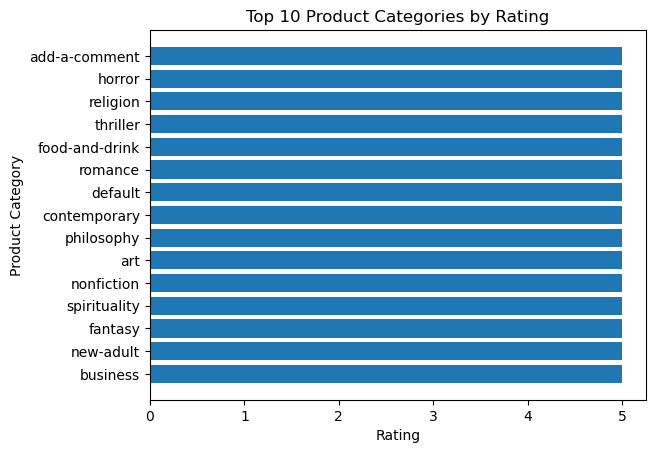

In [75]:
# Trier les données par "rating" en ordre décroissant
top_30_books = Book_Data.sort_values(by="rating", ascending=False).head(30)

# Créer un graphique à barres horizontal pour le Top 10
plt.barh(top_30_books["product_category"], top_30_books["rating"])
plt.xlabel("Rating")
plt.ylabel("Product Category")
plt.title("Top 10 Product Categories by Rating")
#plt.gca().invert_yaxis()  # Inverser l'ordre pour que le plus élevé soit en haut
plt.show()

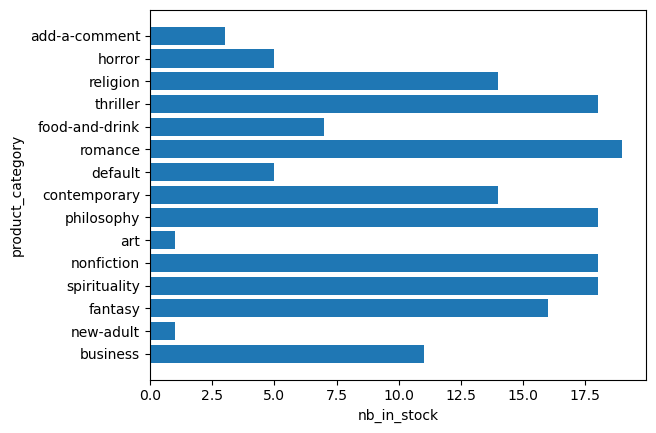

In [76]:
# Trier les données par "rating" en ordre décroissant
plt.barh(top_30_books["product_category"], top_30_books["nb_in_stock"])
plt.xlabel("nb_in_stock")
plt.ylabel("product_category")
plt.show()

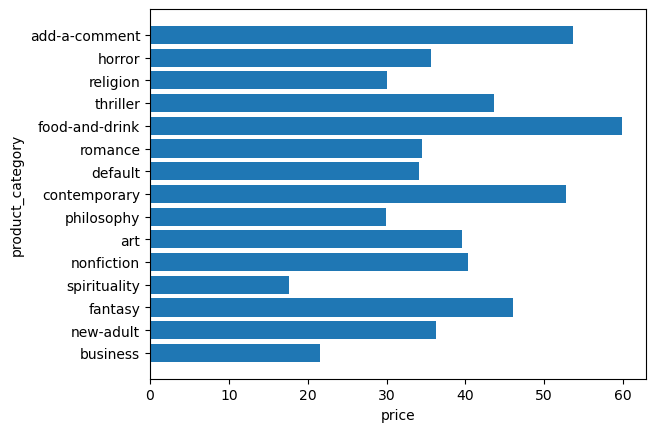

In [77]:
plt.barh(top_30_books["product_category"], top_30_books["price"])
plt.xlabel("price")
plt.ylabel("product_category")
plt.show()

<Axes: ylabel='Density'>

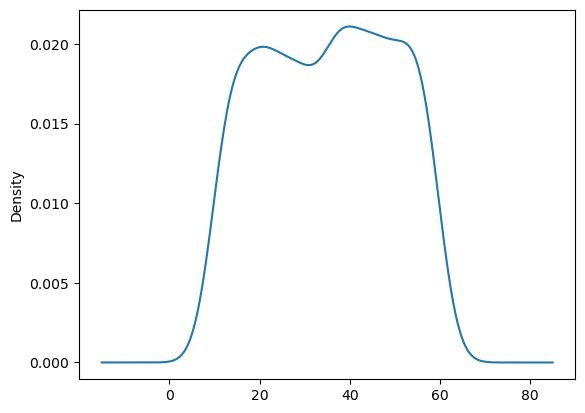

In [78]:
Book_Data["price"].plot.kde() 

<Axes: ylabel='Density'>

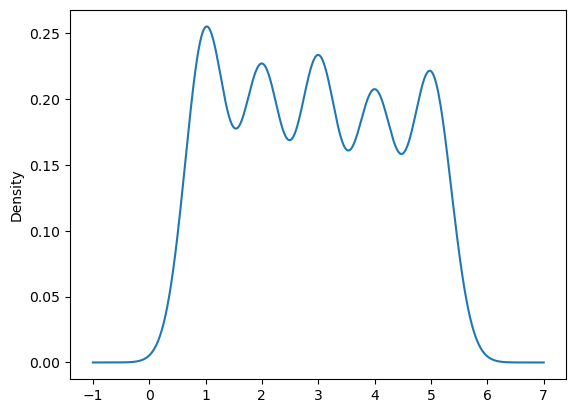

In [79]:
Book_Data["rating"].plot.kde()

<Axes: ylabel='Density'>

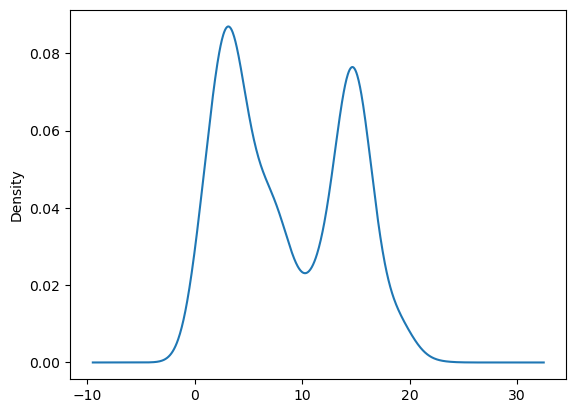

In [80]:
Book_Data["nb_in_stock"].plot.kde()

## Text Clustering

In [81]:
Book_Description = list(Book_Data['description'])
category = list(Book_Data['product_category'])

### Represent each book description as a vector

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Utilisation correcte de 'english' comme chaîne de caractères
vectorizer = TfidfVectorizer(stop_words='english')
# Transformation des descriptions des livres
X = vectorizer.fit_transform(Book_Description)

In [88]:
vectorizer

TfidfVectorizer(stop_words='english')

### Perform k-means clustering

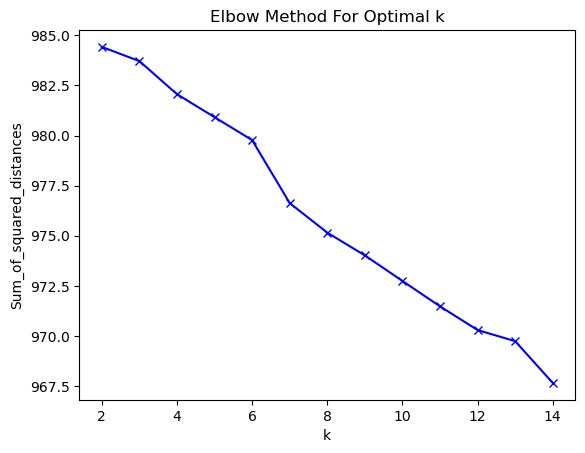

In [94]:
#Plotting the "elbow method" to estimate the number of clusters ( in a cases that we don't know)
Sum_of_squared_distances = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k, max_iter=150, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The line is almost straight, therefore, I think that the algorithm didn't detecte well the number of clusters and maybe that is due the the small number of book descriptions and their similarities in addition to that the text needs more cleaning and dimentionality reduction.

Hence, I expect that the algorithm would have poor perfomance

In [98]:
#We already know the number of clusters, therefore it will be set to 10
true_k = 10
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=150, n_init=15)
model.fit(X)
labels=model.labels_
category_cl=pd.DataFrame(list(zip(category,labels)),columns=['category','cluster'])
print(category_cl.sort_values(by=['cluster']))

             category  cluster
273           fiction        0
756       young-adult        0
462           default        0
77     sequential-art        0
447             music        0
..                ...      ...
620  sports-and-games        9
867             humor        9
868            horror        9
642     add-a-comment        9
267           fiction        9

[1000 rows x 2 columns]


### Evaluate the results

The evaluation of Kmeans algorithm performance would be by checking the books category in each cluster and making a word cloud of the book's description in each cluster 

Cluster: 0
category
           mystery
historical-fiction
historical-fiction
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
          classics
          classics
          classics
          classics
        philosophy
           fiction
           fiction
           fiction
         childrens
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
             music
           default
           default
           default
           default
           default
   science-fiction
     add-a-comment
     add-a-comment
     add-a-comment
           fantasy
           fantasy
       young-adult
            poetry
             humor
             humor
            horror
           history
           history


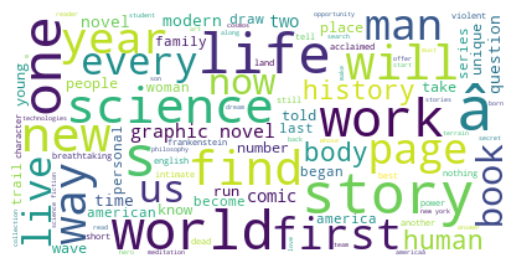

Cluster: 1
category
            travel
            travel
           mystery
           mystery
historical-fiction
historical-fiction
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
          classics
          classics
          classics
        philosophy
           romance
           romance
    womens-fiction
           fiction
           fiction
           fiction
           fiction
           fiction
           fiction
         childrens
         childrens
         childrens
         childrens
         childrens
         childrens
         childrens
         childrens
         childrens
          religion
          religion
          religion
          religion
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        non

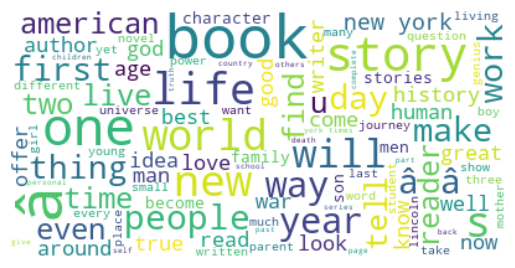

Cluster: 2
category
            travel
           mystery
           mystery
           mystery
           mystery
historical-fiction
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
          classics
          classics
           romance
           romance
           romance
           fiction
           fiction
           fiction
           fiction
           fiction
           fiction
         childrens
         childrens
         childrens
         childrens
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
             music
           default
           default
           default
           default
           default
           default
           

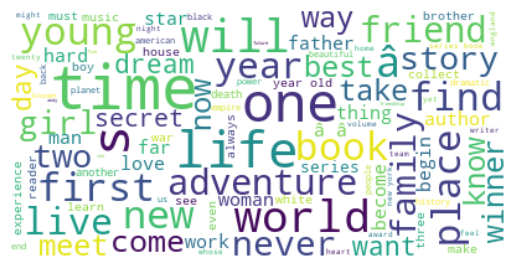

Cluster: 3
category
            travel
           mystery
           mystery
           mystery
           mystery
           mystery
           mystery
           mystery
           mystery
           mystery
           mystery
           mystery
historical-fiction
historical-fiction
historical-fiction
historical-fiction
historical-fiction
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
          classics
          classics
          classics
        philosophy
           romance
           romance
           romance
           romance
    womens-fiction
    womens-fiction
    womens-fiction
           fiction
           fiction
           fiction
           fiction
           fiction
           fiction
           fiction
           fiction
           fiction
           fiction
           fiction
           fiction
           fiction
           fiction
         childrens
         childrens
        non

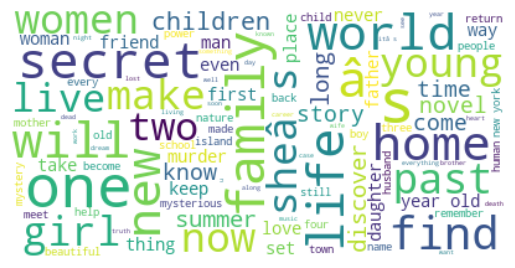

Cluster: 4
category
        travel
    nonfiction
       default
 add-a-comment
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink
food-and-drink


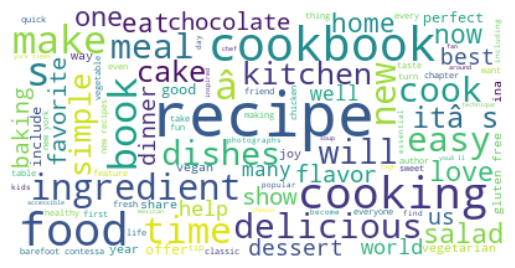

Cluster: 5
category
           mystery
           mystery
           mystery
           mystery
historical-fiction
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
           romance
           romance
           romance
           romance
           romance
           romance
           romance
           romance
           romance
           romance
           romance
    womens-fiction
    womens-fiction
    womens-fiction
    womens-fiction
           fiction
           fiction
           fiction
           fiction
           fiction
           fiction
         childrens
         childrens
         childrens
         childrens
         childrens
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
             music
             music
           

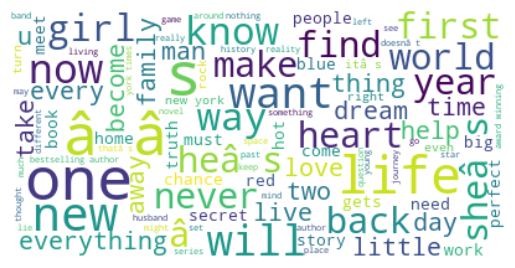

Cluster: 6
category
            travel
            travel
           mystery
historical-fiction
    sequential-art
    sequential-art
          classics
    womens-fiction
           fiction
           fiction
           fiction
           fiction
           fiction
         childrens
         childrens
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
             music
             music
           default
           default
           default
           default
           default
           default
           default
           default
     add-a-comment
     add-a-comment
     add-a-comment
     add-a-comment
     add-a-comment
           fantasy
           science
           science
               art
               art
               art
               art
           

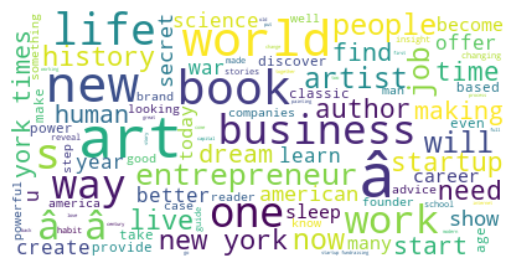

Cluster: 7
category
           mystery
           mystery
           mystery
           mystery
           mystery
historical-fiction
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
          classics
        philosophy
        philosophy
        philosophy
           romance
           romance
           romance
           romance
    womens-fiction
    womens-fiction
           fiction
           fiction
           fiction
           fiction
           fiction
         childrens
         childrens
          religion
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
        nonfiction
             music
           default
           default
           default
           default
           default
           default
           

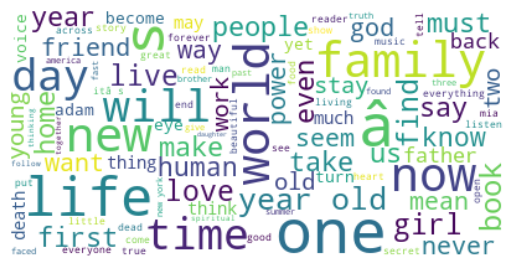

Cluster: 8
category
            travel
            travel
           mystery
historical-fiction
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
    sequential-art
           romance
           romance
    womens-fiction
    womens-fiction
           fiction
           fiction
           fiction
           fiction
           fiction
         childrens
         childrens
         childrens
          religion
        nonfiction
        nonfiction
        nonfiction
           default
           default
           default
           default
           default
           default
           default
           default
           default
           default
           default
           default
           default
           default
           default
           default
           default
           default
   science-

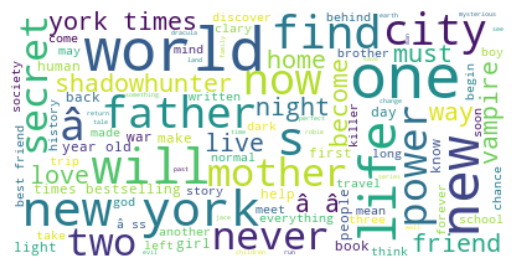

Cluster: 9
category
            travel
            travel
           mystery
           mystery
           mystery
historical-fiction
historical-fiction
historical-fiction
historical-fiction
historical-fiction
historical-fiction
historical-fiction
historical-fiction
historical-fiction
historical-fiction
historical-fiction
historical-fiction
    sequential-art
    sequential-art
    sequential-art
    sequential-art
          classics
          classics
          classics
          classics
          classics
        philosophy
        philosophy
        philosophy
        philosophy
        philosophy
           romance
           romance
           romance
           romance
           romance
           romance
           romance
           romance
           romance
    womens-fiction
    womens-fiction
    womens-fiction
    womens-fiction
           fiction
           fiction
           fiction
           fiction
           fiction
           fiction
           fiction
           

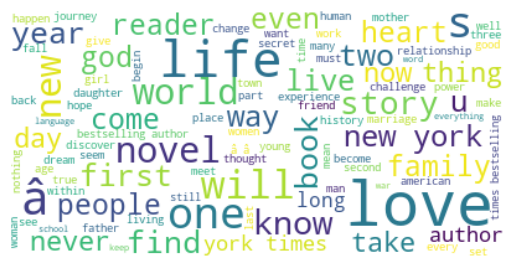

In [99]:
result={'cluster':labels,'description':Book_Description}
result=pd.DataFrame(result)
for k in range(0,true_k):
    s=result[result.cluster==k]
    text=s['description'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    print('category')
    titles=category_cl[category_cl.cluster==k]['category']         
    print(titles.to_string(index=False))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

As it is shown above, this algorithm has poor performance.

In addition the reasons that I provided above of why is algorithm would perform badly, after viewing the word cloud, I see that there is a mix between english and french words, that could also explain this inaccurate perfomance of the algorithm. Hence all the texts should be translated to the same language during the data cleaning befor fitting the algorithm on it.